- $q = d(p) = \beta + \alpha p$
- $\ln q = \ln d(p) = \beta + \alpha \ln p$
- $q = d(p) = C \dfrac{e^{\beta + \alpha p}}{1 + e^{\beta + \alpha p}}$

In [58]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
        'p': np.arange(1, 101, 1)
    }) \
    .assign(
        q_lin=lambda d: 100 - d['p'],
        q_non=lambda d: np.exp(4.5 - 0.5 * np.log(d['p'])),
        q_sig=lambda d: 100 / (1 + np.exp(0.2 * (d['p'] - 50))),
        t_lin=lambda d: d['q_lin'] * (d['p'] - 75),
        t_non=lambda d: d['q_non'] * (d['p'] - 75),
        t_sig=lambda d: d['q_sig'] * (d['p'] - 75)
    )
df.shape

(100, 7)

<Axes: xlabel='p'>

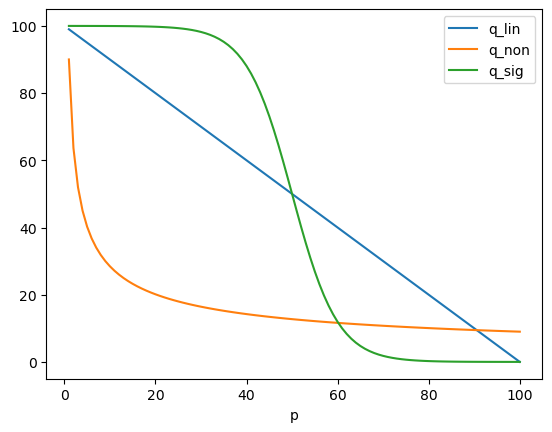

In [60]:
df.set_index(['p'])[['q_lin', 'q_non', 'q_sig']].plot(kind='line')

<Axes: xlabel='p'>

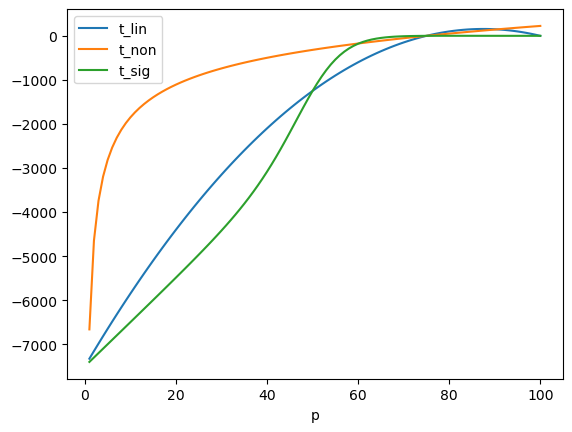

In [61]:
df.set_index(['p'])[['t_lin', 't_non', 't_sig']].plot(kind='line')

In [64]:
df.set_index(['p'])[['t_lin', 't_non', 't_sig']]

,t_lin,t_non,t_sig
p,,,
1,-7326,-6661.267716,-7399.589681
2,-7154,-4646.575849,-7299.505614
3,-6984,-3741.941879,-7199.404436
4,-6816,-3195.608161,-7099.282693
5,-6650,-2817.981946,-6999.136238
...,...,...,...
96,84,192.934035,0.212161
97,66,201.076808,0.181978
98,46,209.141379,0.155766


Total profit $T(p)$.

- $T(p) = d(p) (p - c)$

Optimization is $T'(p) = 0$.

- $T'(p) = d'(p)(p - c) + d(p) = 0$
- $d'(p)(p - c) + d(p) = 0$
- $d'(p)p - d'(p)c + d(p) = 0$
- $d'(p)p + d(p) = d'(p)c$

For linear model, $d'(p) = \alpha$.

- $\alpha p + \beta + \alpha p = \alpha c$
- $2 \alpha p = \alpha c - \beta$
- $p = \dfrac{\alpha c - \beta}{2 \alpha}$

In [17]:
from sklearn.linear_model import LinearRegression

X = df[['p']]
y = df['q_lin']

m = LinearRegression()
m.fit(X, y)

lin_p = pd.Series([m.intercept_, m.coef_[0], 75.0], ['b', 'a', 'c'])
lin_p

b    100.0
a     -1.0
c     75.0
dtype: float64

In [19]:
((lin_p.a * lin_p.c) - lin_p.b) / (2 * lin_p.a)

87.50000000000004

For non-linear model $\epsilon = -\dfrac{d'(p)p}{d(p)}$ and $\epsilon \sim \alpha$.

- $\dfrac{d'(p) p}{d(p)}  + 1 = \dfrac{d'(p) c}{d(p)}$
- $-\epsilon + 1 = \dfrac{\epsilon c}{p}$
- $p = \dfrac{\epsilon c}{-\epsilon + 1} = \dfrac{\epsilon c}{1 - \epsilon} = \dfrac{c}{\dfrac{1}{\epsilon} - 1} = \dfrac{c}{\dfrac{1}{\left| \alpha \right|} - 1}$

In [34]:
X = np.log(df[['p']])
y = np.log(df['q_non'])

m = LinearRegression()
m.fit(X, y)

non_p = pd.Series([m.intercept_, m.coef_[0], 75.0], ['b', 'a', 'c'])
non_p

b     4.5
a    -0.5
c    75.0
dtype: float64

In [35]:
non_p.c / ((1 / np.abs(non_p.a)) - 1)

75.00000000000206

In [55]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import bernoulli

X = df[['p']]
y = bernoulli.rvs(df['q_sig'] / 100)

m = LogisticRegression(random_state=37)
m.fit(X, y)

m.intercept_[0], m.coef_[0][0]

(12.40058359401283, -0.2505168714760109)